# 0.0 Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import pickle

from IPython.display import Image
import datetime

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE

from scipy.stats import chi2_contingency

from boruta import BorutaPy

import requests

import inflection

import time

# Tempo de processamento
time_agora = time.time()

## 0.1 Helper Functions

In [2]:
# outliers by Tukey method
def search_outliers(df, series):
    first_quantile = np.quantile(df[series], 0.25)
    third_quantile = np.quantile(df[series], 0.75)
    distance = (third_quantile - first_quantile) * 1.5
    inf_limit = first_quantile - distance
    sup_limit = third_quantile + distance
    index_outliers = df.loc[(df[series]<inf_limit)|(df[series]>sup_limit)].index
    return index_outliers, inf_limit, sup_limit


# correlations between categorical attributes by Pearson method
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    return round(np.sqrt((chi2corr/n)/( min(kcorr-1, rcorr-1))), 2)


def metrics(y_test, y_hat):
    # metrics
    mean_absolute_error = np.mean(np.abs(np.expm1(y_test) - np.expm1(y_hat))) # mean absolute error
    mean_absolute_percentage_error = np.mean(mean_absolute_error / np.expm1(y_test)) # mean absolute percentage error

    print(f"MAE: {mean_absolute_error}")
    print(f"MAPE: {mean_absolute_percentage_error}")
    print(f"RMSE: {np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_hat)))}")
    

# outliers by Tukey method
def search_outliers(df, series):
    first_quantile = np.quantile(df[series], 0.25)
    third_quantile = np.quantile(df[series], 0.75)
    distance = (third_quantile - first_quantile) * 1.5
    inf_limit = first_quantile - distance
    sup_limit = third_quantile + distance
    index_outliers = df.loc[(df[series]<inf_limit)|(df[series]>sup_limit)].index
    return index_outliers, inf_limit, sup_limit


# correlations between categorical attributes by Pearson method
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    return round(np.sqrt((chi2corr/n)/( min(kcorr-1, rcorr-1))), 2)


def metrics(y_test, y_hat):
    # metrics
    mean_absolute_error = np.mean(np.abs(np.expm1(y_test) - np.expm1(y_hat))) # mean absolute error
    mean_absolute_percentage_error = np.mean(mean_absolute_error / np.expm1(y_test)) # mean absolute percentage error

    print(f"MAE: {mean_absolute_error}")
    print(f"MAPE: {mean_absolute_percentage_error}")
    print(f"RMSE: {np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_hat)))}")
    

def cross_validation(df, error, kfold, model_name, model):
    list_mean_absolute_error, list_mean_absolute_percentage_error, list_root_mean_squared_error, folds = [], [], [], []
    for i in reversed(range(1, kfold+1)):
        folds.append(f'Fold: {i}')
        validation_start_date = df['date'].max() - pd.Timedelta(6*i, 'w')
        validation_end_date = df['date'].max() - pd.Timedelta(6*(i-1), 'w')
        
        train = df[df['date']<validation_start_date]
        validation = df[(df['date']>=validation_start_date)&(df['date']<=validation_end_date)]
        
        X_train = train.drop(['sales', 'store', 'date'], axis=1)
        y_train = train['sales']
        
        X_val = validation.drop(['sales', 'store', 'date'], axis=1)
        y_val = validation['sales']
        
        # fiting model
        model_fit = model.fit(X_train, y_train)

        # predicting
        y_hat = model_fit.predict(X_val)
        
        list_mean_absolute_error.append(np.mean(np.abs(np.expm1(y_val) - np.expm1(y_hat))))
        list_mean_absolute_percentage_error.append(np.mean(np.abs(np.expm1(y_val) - np.expm1(y_hat)) / np.expm1(y_val)))
        list_root_mean_squared_error.append(np.sqrt(mean_squared_error(np.expm1(y_val), np.expm1(y_hat))))
        
    # mean and std
    folds.append('mean_and_std')
    list_mean_absolute_error.append(str(round(np.mean(list_mean_absolute_error), 2))+' +/- '+str(round(np.std(list_mean_absolute_error), 2)))
    list_mean_absolute_percentage_error.append(str(round(np.mean(list_mean_absolute_percentage_error), 2))+' +/- '+str(round(np.std(list_mean_absolute_percentage_error), 2)))
    list_root_mean_squared_error.append(str(round(np.mean(list_root_mean_squared_error), 2))+' +/- '+str(round(np.std(list_root_mean_squared_error), 2)))
    # dataframe
    cross_validation_metrics = pd.DataFrame([list_mean_absolute_error, list_mean_absolute_percentage_error, list_root_mean_squared_error], index=['MAE', 'MAPE', "RMSE"], columns=folds)
    error[model_name] = cross_validation_metrics['mean_and_std']
    return error, cross_validation_metrics

## 0.2 Loading Data

In [3]:
store = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\data\\raw\\store.csv', low_memory=False)
train = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\data\\raw\\train.csv', low_memory=False)
test_raw = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\data\\raw\\test.csv', low_memory=False)

df_raw = pd.merge(train, store, how='left', on='Store')
df = df_raw.copy()
test_raw = pd.merge(test_raw, store, how='left', on='Store')
test = test_raw.copy()
df.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
670502,58,4,2013-11-07,6148,540,1,1,0,0,a,c,7340.0,5.0,2008.0,1,27.0,2012.0,"Jan,Apr,Jul,Oct"
764655,551,4,2013-08-15,6188,1048,1,1,0,0,a,c,2190.0,9.0,2013.0,0,NaN,NaN,NaN
696405,316,2,2013-10-15,7258,725,1,0,0,0,d,a,9000.0,8.0,2001.0,0,NaN,NaN,NaN
273782,3,5,2014-11-21,5865,737,1,0,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
357211,264,7,2014-08-24,0,0,0,0,0,0,a,a,180.0,3.0,2014.0,0,NaN,NaN,NaN


# 1.0 Data Description

In [4]:
df1 = df.copy()

## 1.1 Rename Columns

In [5]:
snake_case = lambda x: inflection.underscore(x)

cols_old = df1.columns.to_list()
cols_new = list(map(snake_case, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data Dimension

In [6]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [7]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [8]:
# changing date datatype
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

Os valores NaN's estão ligados a dois atributos:
- Competidores: ou não há competidores ou estão em um raio grande demais
- Promo2: não foi ativada a promo2 por qualquer motivo

## 1.5 Fillout NA

In [10]:
# competition_distance
constant_competition_distance = 200000
df1.loc[df1['competition_distance'].isna(), 'competition_distance'] = constant_competition_distance

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if np.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if np.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
df1['promo_interval'].fillna(0, inplace=True)
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
df1.drop(['promo_interval', 'month_map'], axis=1, inplace=True)

## 1.6 Change Data Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int')

## 1.7 Descriptive Statistical

### 1.7.1 Classifying Attributes

In [12]:
num_attributes = ['sales', 'customers', 'competition_distance']
cat_attributes = ['open', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'day_of_week', 'promo', 'promo2', 'is_promo']

### 1.7.2 Numerical Attributes

In [13]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(df1[num_attributes].apply(np.mean)).T
ct2 = pd.DataFrame(df1[num_attributes].apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(df1[num_attributes].apply(np.std)).T
d2 = pd.DataFrame(df1[num_attributes].apply(min)).T
d3 = pd.DataFrame(df1[num_attributes].apply(max)).T
d4 = pd.DataFrame(df1[num_attributes].apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df1[num_attributes].apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1[num_attributes].apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
m.columns = 'min max range mean median std skew kurtosis'.split()
m

,min,max,range,mean,median,std,skew,kurtosis
sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712


1. sales: a média e a mediana estão próximas, isso indica uma distribuição centralizada na média, a skew é baixa, o que reforça uma distribuição centralizada na média, indicando uma distribuição próxima a uma normal, a skew é positiva, então tem uma cauda direita um pouco mais pesada, kurtosis próxima de 1, inidica um pico não muito alto. A distribuição deve ser parecida com uma NORMAL.
2. customers: a média e a mediana estão prõximas mas com uma diferença de uns 5 porcento, a skew próxima a 1.5 indica um deslocamento da centralização relativamente pequeno, a skew é positiva, então tem uma cauda direita mais pesada, a kurtosis é média, sugerindo um pico relativamente alto. A distribuição pode ser parecida com uma NORMAL.
3. competition_distance: a média e a mediana estão bastante distantes, a skew é altíssima, o que sugerem que a média e a mediana estão bastante deslocadas, é a skew é positiva, portanto uma cauda direita bem mais pesada, a kurtosis é altíssima, o que aponta um pico bastante alto, com uma alta concentração, não centralizada na média, distribuição parece uma POISSON.

### 1.7.3 Categorical Attributes

In [14]:
df1[cat_attributes].apply(lambda x: x.nunique())

open              2
state_holiday     4
school_holiday    2
store_type        4
assortment        3
day_of_week       7
promo             2
promo2            2
is_promo          2
dtype: int64

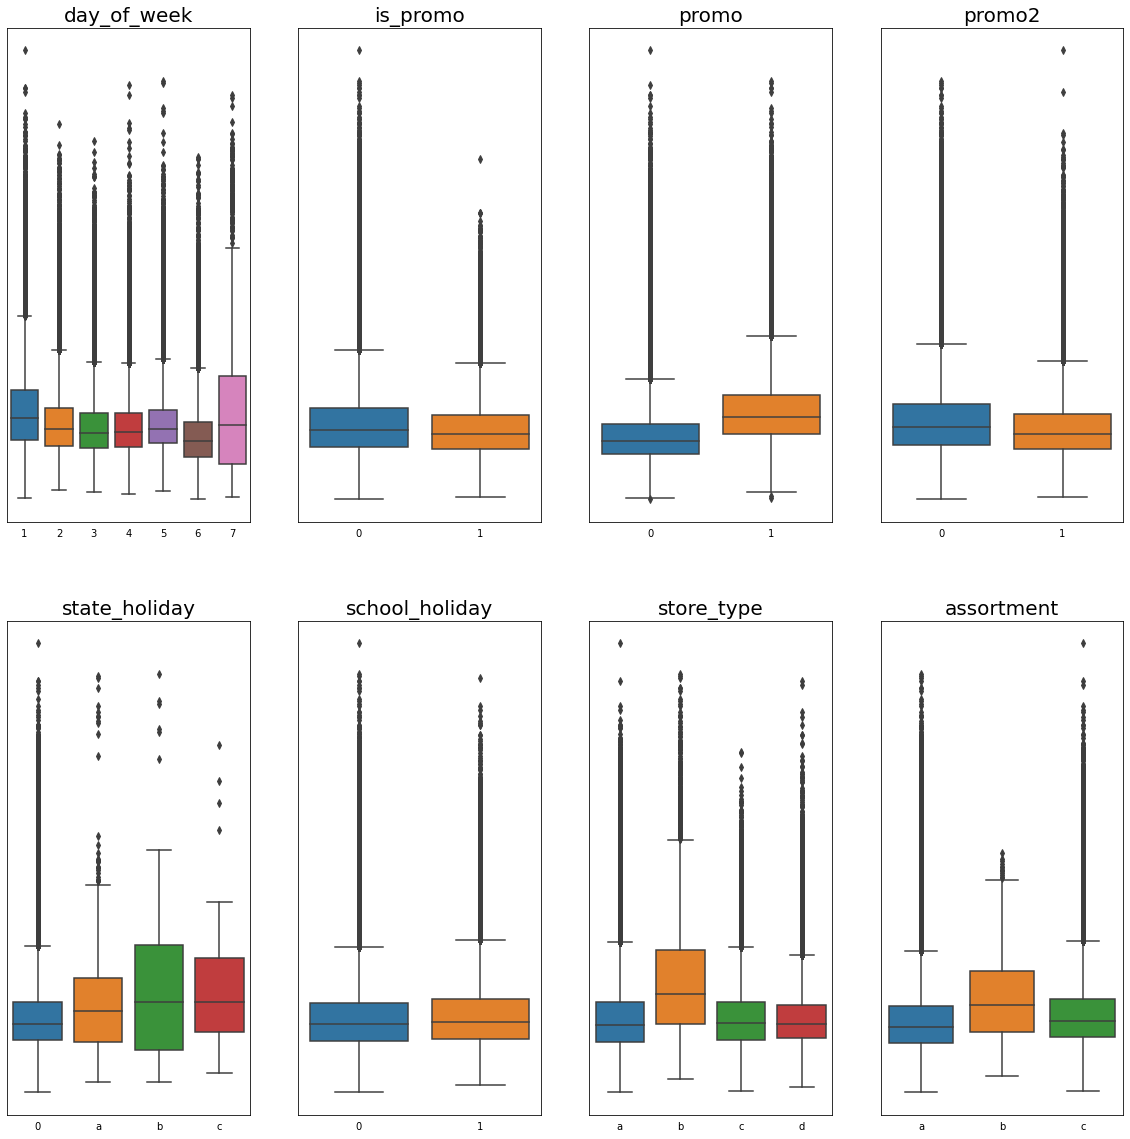

In [15]:
temp = df1[cat_attributes].astype('category')
temp['sales'] = df1['sales']
temp = temp.loc[temp['sales']>0]

plt.figure(figsize=(20, 20))

plt.subplot(2, 4, 1)
ax = sns.boxplot(x='day_of_week', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('day_of_week', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 2)
ax = sns.boxplot(x='is_promo', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('is_promo', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 3)
ax = sns.boxplot(x='promo', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('promo', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 4)
ax = sns.boxplot(x='promo2', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('promo2', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 5)
ax = sns.boxplot(x='state_holiday', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('state_holiday', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 6)
ax = sns.boxplot(x='school_holiday', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('school_holiday', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 7)
ax = sns.boxplot(x='store_type', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('store_type', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 8)
ax = sns.boxplot(x='assortment', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('assortment', fontsize=20)
plt.xlabel('')
plt.ylabel('');

1. domingos têm uma distribuição mais espalhada, com maior variância
2. promoções do tipo promo aumentam as vendas
4. feriados geram vendas relativamente maiores e com maior variância
6. store_type do tipo b claramente têm maiores vendas

# 2.0 Feature Engineering

In [16]:
df2 = df1.copy()

## 2.1 Hypothesis Mindmap

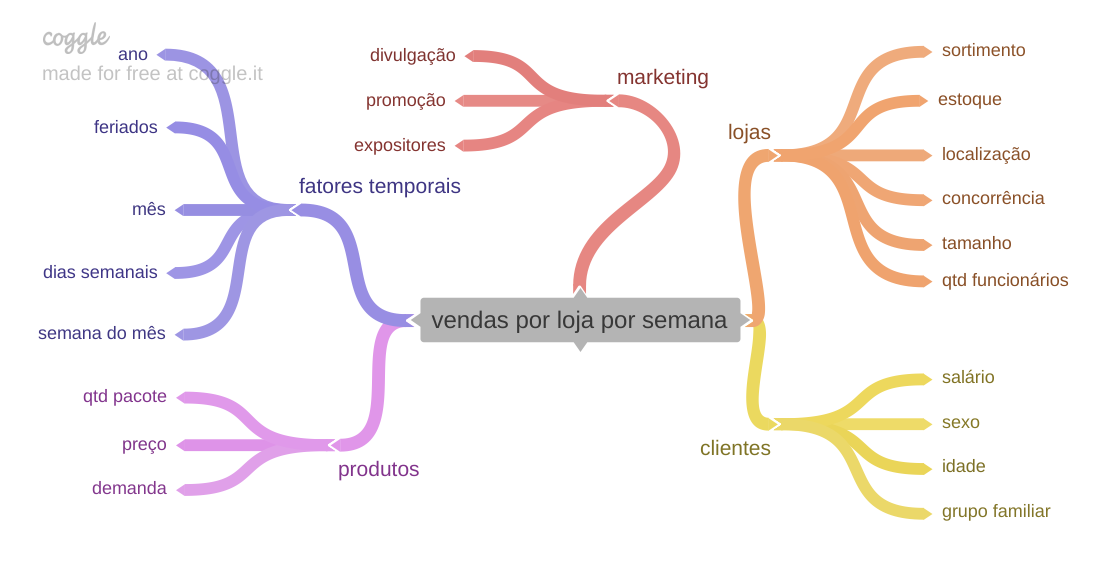

In [17]:
Image('..\\img\\mind_map_hypothesis.png')

## 2.2 Creating Hypothesis

### 2.2.1 Temporal Factors:
1. Com o passar dos anos, as lojas deveriam vender mais.
2. Aos feriados, as lojas deveriam vender mais.
3. Aos ultimos trimestres, as lojas deveriam vender mais.
4. Aos finais de semana, as lojas deveriam vender mais.
5. Às ultimas semanas dos meses, as lojas deveriam vender MENOS.

### 2.2.2 Marketing:
6. Lojas que fazem maior investimento em divulgações, deveriam vender mais.
7. Lojas em Períodos de promoções, deveriam vender mais.
8. Lojas com promoções a mais tempo, deveriam vender mais.
9. Lojas com melhores estruturas de expositores, deveriam vender mais.

### 2.2.3 Clients:
10. Lojas com clientes com maiores salários, deveriam vender mais.
11. Lojas com uma proporção maior de público feminino, deveriam vender mais.
12. Lojas com clientes de faixa etária relativamente maior, deveriam vender mais.
13. Lojas com clientes com grupos familiares maiores, deveriam vender mais.

### 2.2.4 Products:
14. Produtos com pacotes unitários maiores deveriam promover maiores vendas.
15. Produtos com margem de lucro reduzida, deveriam promover maiores vendas.
16. Produtos com maiores demandas, deveriam promover maiores vendas.

### 2.2.5 Stores:
17. Lojas com maior sortimento, deveriam vender mais.
18. Lojas com maiores disponibilidades de estoque, deveriam vender mais.
19. Lojas localizadas em regiões com maiores salários, deveriam vender mais.
20. Lojas com concorrência mais próxima, deveriam vender MENOS.
21. Lojas com concorrência a mais tempo, deveriam vender mais.
22. Lojas de maior porte, deveriam vender mais.
23. Lojas com mais colaboradores, deveriam vender mais.

### 2.2.5 Lista final de hipóteses:

As hipóteses em negrito foram selecionadas e serão estudadas primeiro. O principal critério para selecionar as possíveis hipóteses foi a disponibilidade de features que possibilitem os estudos.

1. Com o passar dos anos, as lojas deveriam vender mais.
2. Aos feriados, as lojas deveriam vender mais.
3. Aos ultimos trimestres, as lojas deveriam vender mais.
4. Aos finais de semana, as lojas deveriam vender mais.
5. Às ultimas semanas dos meses, as lojas deveriam vender MENOS.
6. Lojas em Períodos de promoções, deveriam vender mais.
7. Lojas com promoções a mais tempo, deveriam vender mais.
8. Lojas com maior sortimento, deveriam vender mais.
9. Lojas com concorrência mais próxima, deveriam vender MENOS.
10. Lojas com mais colaboradores, deveriam vender mais.

## 2.3 Creating Features

In [18]:
# week
df2['week'] = df2['date'].dt.isocalendar().week

# year
df2['year'] = df2['date'].dt.year

# quarters
df2['year_quarters'] = df2['date'].dt.month.apply(lambda x: 1 if x <= 3 else (2 if x <= 6 else (3 if x <= 9 else 4)))

# weekends
df2['weekends'] = df2['date'].dt.day_name().apply(lambda x: 0 if x not in ['Friday', 'Saturday'] else 1)

# last_week_of_month
df2['last_week_of_month'] = df2['date'].dt.day.apply(lambda x: 0 if x <= 23 else 1)

# competition_since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(day=1, month=x['competition_open_since_month'], year=x['competition_open_since_year']), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int')
df2.drop(['competition_since', 'competition_open_since_month', 'competition_open_since_year'], axis=1, inplace=True)

# promo_since
df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo2_since'] = df2['promo2_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo2_time_week'] = ((df2['date'] - df2['promo2_since']) / 7).apply(lambda x: x.days).astype(int)
df2.drop(['promo2_since', 'promo2_since_year', 'promo2_since_week'], axis=1, inplace=True)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

# day_of_week
df2['day_of_week'] = df2['date'].dt.day_name()

num_attributes.extend(['competition_time_month', 'promo2_time_week'])

cat_attributes.extend(['week', 'year', 'year_quarters', 'weekends', 'last_week_of_month', 'day_of_week'])

# 3.0 Exploratory Data Analysis

In [19]:
df3 = df2.copy()

## 3.1 Univariate Analysis

### 3.1.1 Response variable

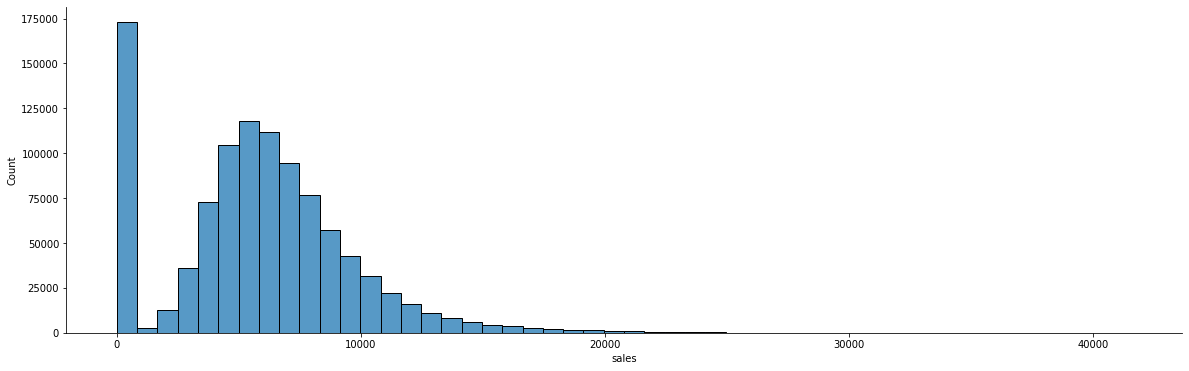

In [20]:
plt.figure(figsize=(20, 6))
sns.histplot(df3['sales'], bins=50)
sns.despine();

Uma distribuição normal, com uma skew positiva, com uma média próxima a 5000

### 3.1.2 Numerical variables

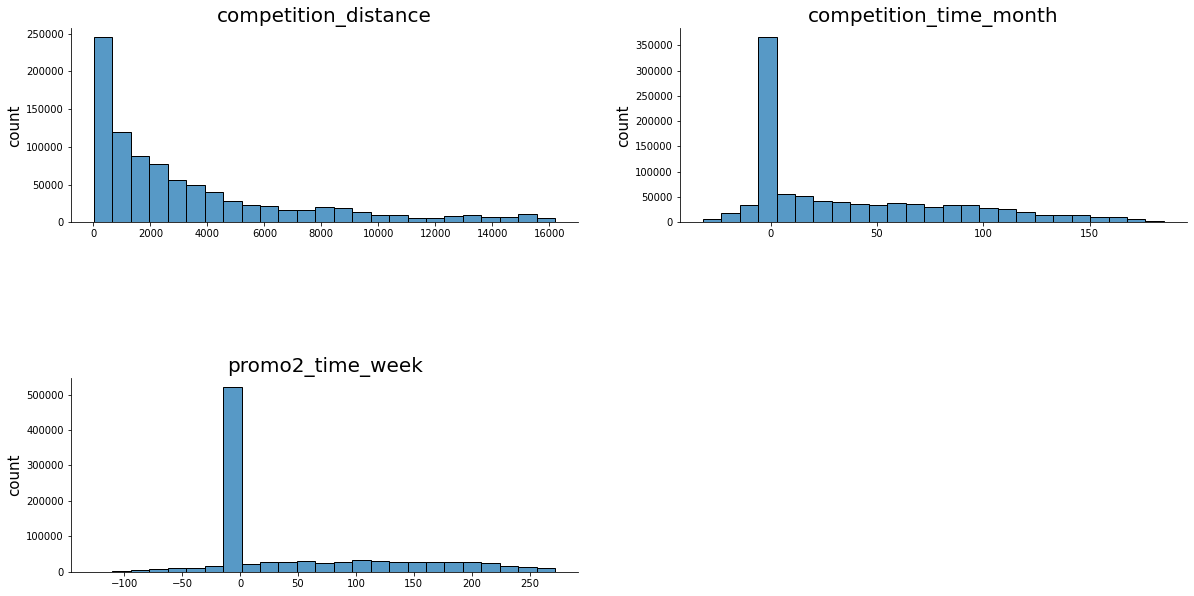

In [21]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.8)

plt.subplot(2, 2, 1)
outliers_indices, li, ls = search_outliers(df3, 'competition_distance')
temp = df3.drop(outliers_indices)
sns.histplot(temp['competition_distance'], bins=25)
sns.despine()
plt.title('competition_distance', fontsize=20)
plt.xlabel('')
plt.ylabel('count', fontsize=15)

plt.subplot(2, 2, 2)
outliers_indices, li, ls = search_outliers(df3, 'competition_time_month')
temp = df3.drop(outliers_indices)
sns.histplot(temp['competition_time_month'], bins=25)
sns.despine()
plt.title('competition_time_month', fontsize=20)
plt.xlabel('')
plt.ylabel('count', fontsize=15)

plt.subplot(2, 2, 3)
outliers_indices, li, ls = search_outliers(df3, 'promo2_time_week')
temp = df3.drop(outliers_indices)
sns.histplot(temp['promo2_time_week'], bins=25)
sns.despine()
plt.title('promo2_time_week', fontsize=20)
plt.xlabel('')
plt.ylabel('count', fontsize=15);

1. Customers apresenta uma distribuição próxima a uma normal, com uma skew levemente positiva.
2. A maioria das lojas tem concorrência bastante próxima, uma distribuição parecida com uma Poisson, com uma skew positiva.
3. Competition_time_month com valores bem distribuidos e esparsos.
4. promo2_time_week com valores bem distribuídos e esparços.

### 3.1.2 Categorical variables

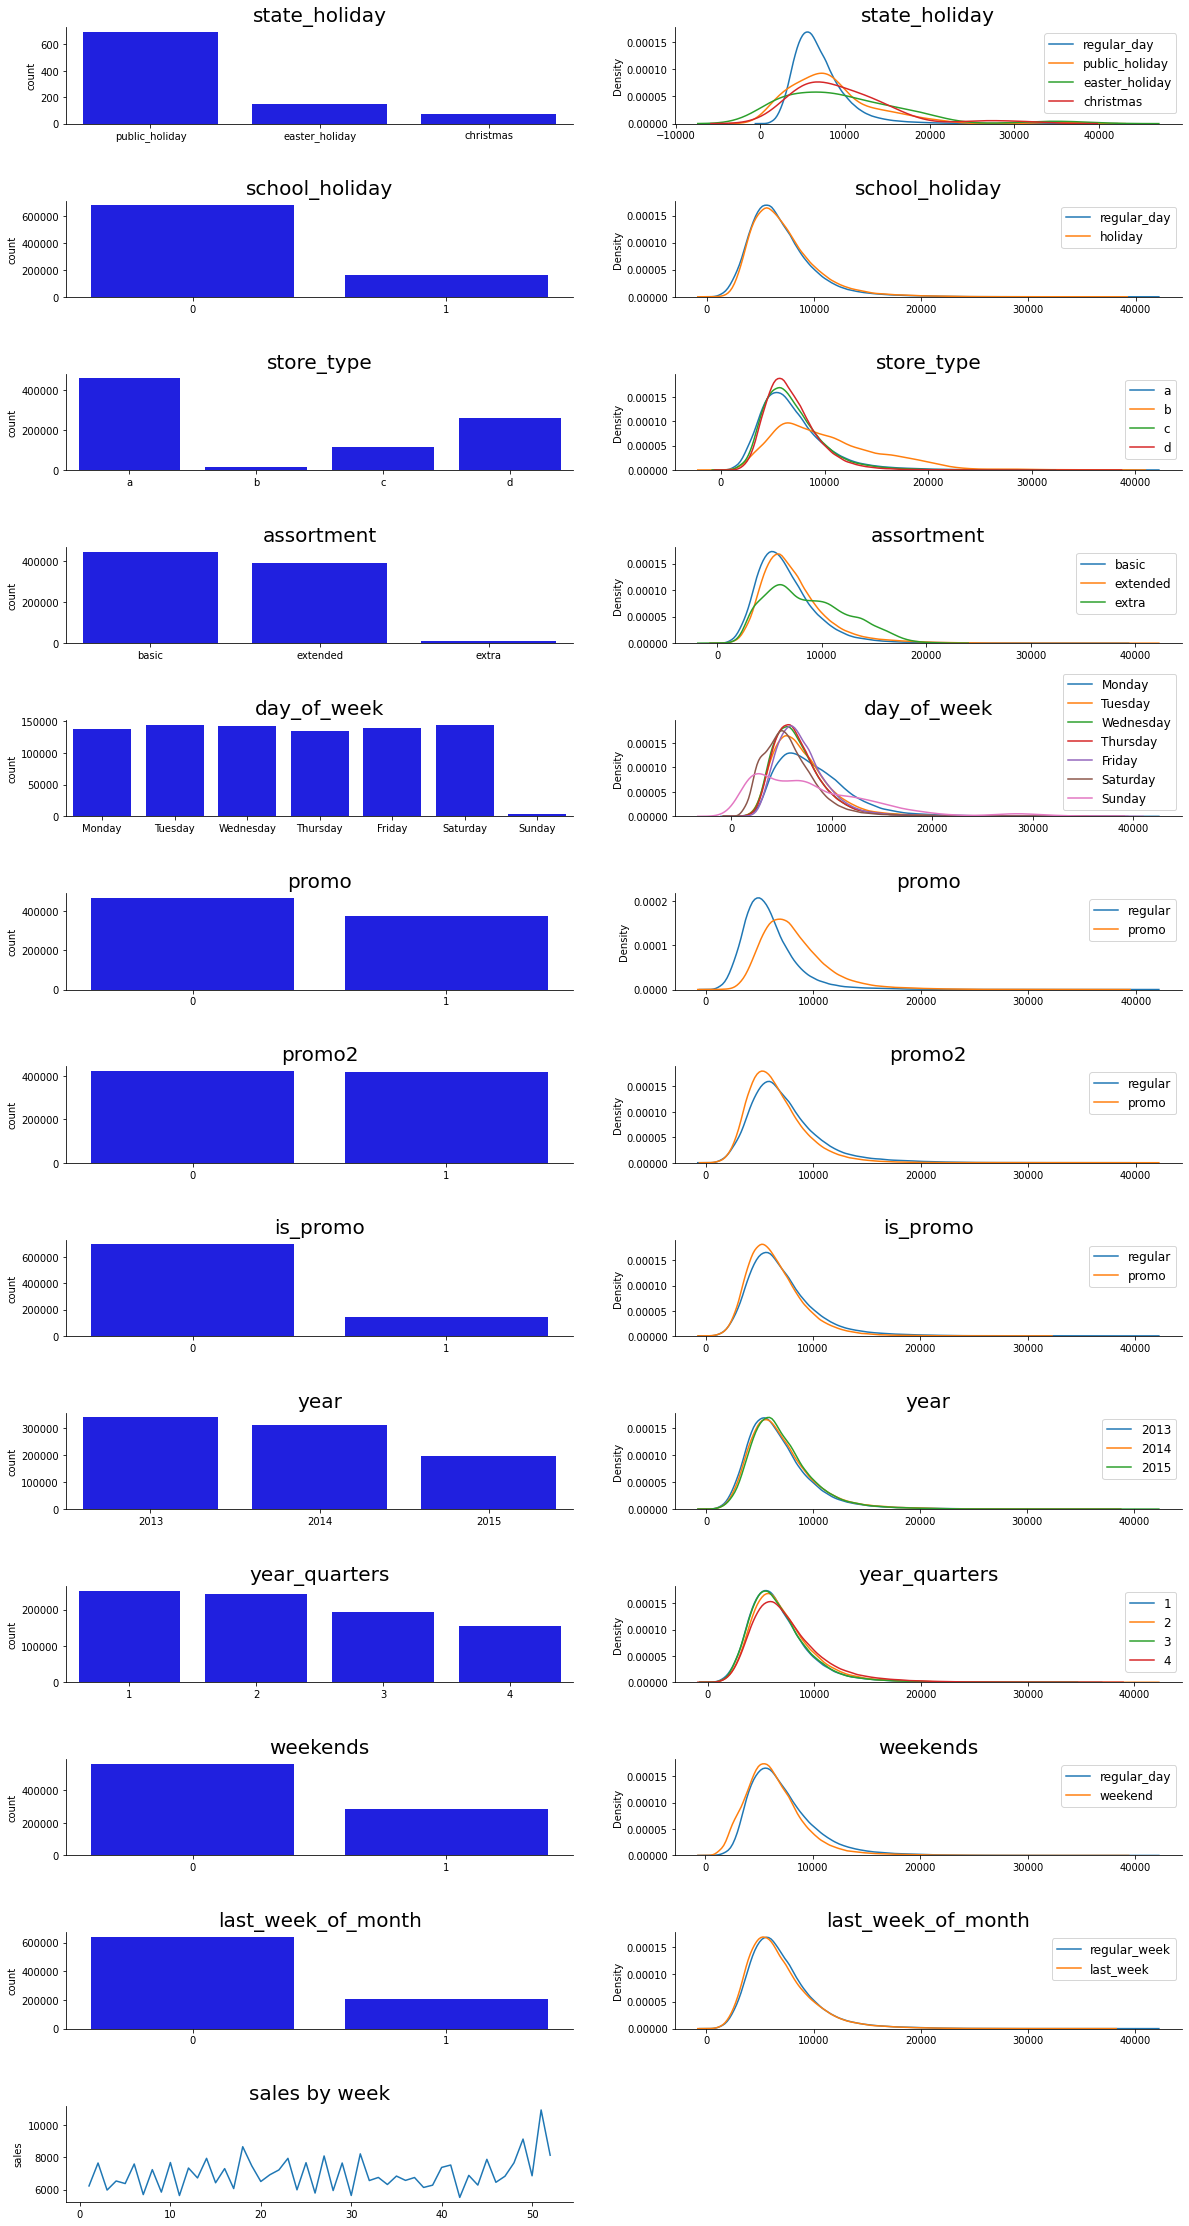

In [22]:
temp = df3.loc[df3['open']==1]

plt.figure(figsize=(20, 40))
plt.subplots_adjust(hspace=0.8)

# state_holiday
temp1 = temp[temp['state_holiday']!='regular_day']
plt.subplot(13, 2, 1)
sns.countplot(x='state_holiday', data=temp1, color='b')
plt.title('state_holiday', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(13, 2, 2)
sns.kdeplot(x='sales', data=temp.loc[temp['state_holiday']=='regular_day'], label='regular_day')
sns.kdeplot(x='sales', data=temp.loc[temp['state_holiday']=='public_holiday'], label='public_holiday')
sns.kdeplot(x='sales', data=temp.loc[temp['state_holiday']=='easter_holiday'], label='easter_holiday')
sns.kdeplot(x='sales', data=temp.loc[temp['state_holiday']=='christmas'], label='christmas')
plt.title('state_holiday', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# school_holiday
plt.subplot(13, 2, 3)
sns.countplot(x='school_holiday', data=temp, color='b')
plt.title('school_holiday', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(13, 2, 4)
sns.kdeplot(x='sales', data=temp.loc[temp['school_holiday']==0], label='regular_day')
sns.kdeplot(x='sales', data=temp.loc[temp['school_holiday']==1], label='holiday')
plt.title('school_holiday', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# store_type
plt.subplot(13, 2, 5)
sns.countplot(x='store_type', data=temp, color='b', order=['a', 'b', 'c', 'd'])
plt.title('store_type', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(13, 2, 6)
sns.kdeplot(x='sales', data=temp.loc[temp['store_type']=='a'], label='a')
sns.kdeplot(x='sales', data=temp.loc[temp['store_type']=='b'], label='b')
sns.kdeplot(x='sales', data=temp.loc[temp['store_type']=='c'], label='c')
sns.kdeplot(x='sales', data=temp.loc[temp['store_type']=='d'], label='d')
plt.title('store_type', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# assortment
plt.subplot(13, 2, 7)
sns.countplot(x='assortment', data=temp, color='b', order=['basic', 'extended', 'extra'])
plt.title('assortment', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(13, 2, 8)
sns.kdeplot(x='sales', data=temp.loc[temp['assortment']=='basic'], label='basic')
sns.kdeplot(x='sales', data=temp.loc[temp['assortment']=='extended'], label='extended')
sns.kdeplot(x='sales', data=temp.loc[temp['assortment']=='extra'], label='extra')
plt.title('assortment', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# day_of_week
plt.subplot(13, 2, 9)
sns.countplot(x='day_of_week', data=temp, color='b', order= 'Monday Tuesday Wednesday Thursday Friday Saturday Sunday'.split())
plt.title('day_of_week', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(13, 2, 10)
sns.kdeplot(x='sales', data=temp.loc[temp['day_of_week']=='Monday'], label='Monday')
sns.kdeplot(x='sales', data=temp.loc[temp['day_of_week']=='Tuesday'], label='Tuesday')
sns.kdeplot(x='sales', data=temp.loc[temp['day_of_week']=='Wednesday'], label='Wednesday')
sns.kdeplot(x='sales', data=temp.loc[temp['day_of_week']=='Thursday'], label='Thursday')
sns.kdeplot(x='sales', data=temp.loc[temp['day_of_week']=='Friday'], label='Friday')
sns.kdeplot(x='sales', data=temp.loc[temp['day_of_week']=='Saturday'], label='Saturday')
sns.kdeplot(x='sales', data=temp.loc[temp['day_of_week']=='Sunday'], label='Sunday')
plt.title('day_of_week', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# promo
plt.subplot(13, 2, 11)
sns.countplot(x='promo', data=temp, color='b')
plt.title('promo', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(13, 2, 12)
sns.kdeplot(x='sales', data=temp.loc[temp['promo']==0], label='regular')
sns.kdeplot(x='sales', data=temp.loc[temp['promo']==1], label='promo')
plt.title('promo', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# promo2
plt.subplot(13, 2, 13)
sns.countplot(x='promo2', data=temp, color='b')
plt.title('promo2', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(13, 2, 14)
sns.kdeplot(x='sales', data=temp.loc[temp['promo2']==0], label='regular')
sns.kdeplot(x='sales', data=temp.loc[temp['promo2']==1], label='promo')
plt.title('promo2', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# is_promo
plt.subplot(13, 2, 15)
sns.countplot(x='is_promo', data=temp, color='b')
plt.title('is_promo', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(13, 2, 16)
sns.kdeplot(x='sales', data=temp.loc[temp['is_promo']==0], label='regular')
sns.kdeplot(x='sales', data=temp.loc[temp['is_promo']==1], label='promo')
plt.title('is_promo', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# year
plt.subplot(13, 2, 17)
sns.countplot(x='year', data=temp, color='b')
plt.title('year', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(13, 2, 18)
sns.kdeplot(x='sales', data=temp.loc[temp['year']==2013], label='2013')
sns.kdeplot(x='sales', data=temp.loc[temp['year']==2014], label='2014')
sns.kdeplot(x='sales', data=temp.loc[temp['year']==2015], label='2015')
plt.title('year', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# year_quarters
plt.subplot(13, 2, 19)
sns.countplot(x='year_quarters', data=temp, color='b')
plt.title('year_quarters', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(13, 2, 20)
sns.kdeplot(x='sales', data=temp.loc[temp['year_quarters']==1], label='1')
sns.kdeplot(x='sales', data=temp.loc[temp['year_quarters']==2], label='2')
sns.kdeplot(x='sales', data=temp.loc[temp['year_quarters']==3], label='3')
sns.kdeplot(x='sales', data=temp.loc[temp['year_quarters']==4], label='4')
plt.title('year_quarters', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# weekends
plt.subplot(13, 2, 21)
sns.countplot(x='weekends', data=temp, color='b')
plt.title('weekends', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(13, 2, 22)
sns.kdeplot(x='sales', data=temp.loc[temp['weekends']==0], label='regular_day')
sns.kdeplot(x='sales', data=temp.loc[temp['weekends']==1], label='weekend')
plt.title('weekends', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# last_week_of_month
plt.subplot(13, 2, 23)
sns.countplot(x='last_week_of_month', data=temp, color='b')
plt.title('last_week_of_month', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(13, 2, 24)
sns.kdeplot(x='sales', data=temp.loc[temp['last_week_of_month']==0], label='regular_week')
sns.kdeplot(x='sales', data=temp.loc[temp['last_week_of_month']==1], label='last_week')
plt.title('last_week_of_month', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# week
plt.subplot(13, 2, 25)
temp3 = temp.groupby('week').agg({'sales':'mean'}).reset_index()
sns.lineplot(data=temp3, x='week', y='sales')
plt.title('sales by week', fontsize=20)
plt.xlabel('')
sns.despine();

## 3.2 Bivariate Analysis

#### H1 Com o passar dos anos, as lojas deveriam vender mais.

Hipótese refutada, as vendas permanecem estáveis com o passar dos anos

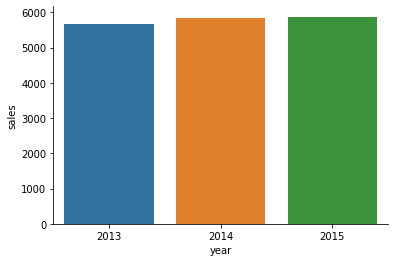

In [23]:
temp = df3.groupby('year').agg({'sales':'mean'}).reset_index()
sns.barplot(x='year', y='sales', data=temp)
sns.despine();

#### H2 Aos feriados, as lojas deveriam vender mais

#### H3 Aos ultimos trimestres, as lojas deveriam vender mais.

#### H4 Aos finais de semana, as lojas deveriam vender mais.

#### H5 Às ultimas semanas dos meses, as lojas deveriam vender MENOS.**.

#### H6 Períodos de promoções, deveriam vender mais.

#### H7 Lojas com promoções a mais tempo, deveriam vender mais.

#### H8 Lojas com maior sortimento, deveriam vender mais.

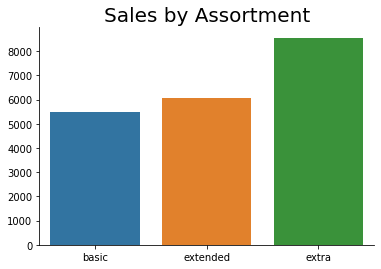

In [24]:
temp = df3.groupby('assortment').agg({'sales':'mean'}).reset_index()
sns.barplot(x='assortment', y='sales', data=temp)
sns.despine()
plt.ylabel('')
plt.xlabel('')
plt.title('Sales by Assortment', fontsize=20);

#### H9 Lojas com concorrência mais próxima, deveriam vender **MENOS**.

#### H10 Lojas com concorrência a mais tempo, deveriam vender mais.

## 3.3 Multivariate Analysis

### 3.3.1 Numerical Attributes

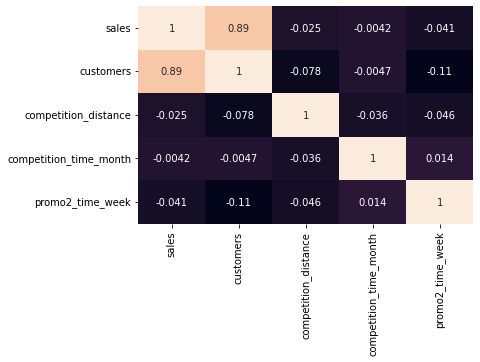

In [25]:
sns.heatmap(df3[num_attributes].corr(), annot=True, cbar=False);

### 3.3.2 Categorical Attributes

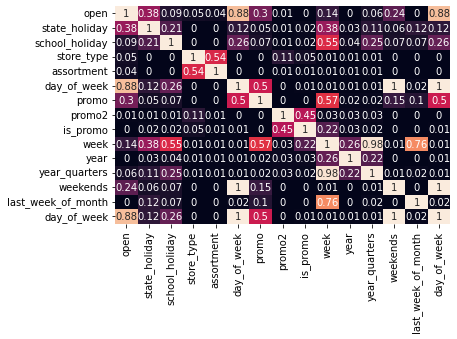

In [26]:
cramer_correlation = []

for i, col_1 in enumerate(cat_attributes):
    for j, col_2 in enumerate(cat_attributes):
        cramer_correlation.append(cramer_v(df3[col_1], df3[col_2]))
        
matrix = pd.DataFrame(np.array(cramer_correlation).reshape(15, 15), index=cat_attributes, columns=cat_attributes)

sns.heatmap(matrix, annot=True, cbar=False);

# 4.0 Data Filtering

In [27]:
df4 = df3.copy()

## 4.1 Rows filtering

Filtrando lojas fechadas

In [28]:
df4 = df4.loc[df4['open']!=0]
df4 = df4.loc[df4['sales']>0]

## 4.2 Columns filtering

In [29]:
cols_filtering = ['open', 'customers']
df4 = df4.drop(cols_filtering, axis=1)

num_attributes.remove('customers')
cat_attributes.remove('open')

A coluna customer não poderá seguir para a modelagem, mas permanecerá no dataset para participar da análise exploratória de dados

# 5.0 Data Preparation

In [30]:
df5 = df4.copy()

## 5.1 Features

### 5.1.1 Normalization

### 5.1.2 Rescalling

In [31]:
# 'competition_distance'
rs_competition_distance = RobustScaler().fit(df5[['competition_distance']].values)
df5['competition_distance'] = rs_competition_distance.transform(df5[['competition_distance']].values)

# 'competition_time_month'
rs_competition_time_month = RobustScaler().fit(df5[['competition_time_month']].values)
df5['competition_time_month'] = rs_competition_distance.transform(df5[['competition_time_month']].values)

# 'promo2_time_week'
mm_promo2_time_week = MinMaxScaler().fit(df5[['promo2_time_week']].values)
df5['promo2_time_week'] = mm_promo2_time_week.transform(df5[['promo2_time_week']].values)

### 5.1.3 Transformation

#### 5.1.3.1 Encoding

In [32]:
# 'state_holiday'
map_state_holiday = {'regular_day': 0, 'public_holiday':1, 'easter_holiday':2, 'christmas':3}
df5['state_holiday'] = df5['state_holiday'].map(map_state_holiday)

# 'store_type'
map_store_type = {'a':1, 'b':2, 'c':3, 'd':4}
df5['store_type'] = df5['store_type'].map(map_store_type)

# 'assortment'
map_assortment = {'basic':1, 'extended':2, 'extra':3}
df5['assortment'] = df5['assortment'].map(map_assortment)

# 'year'
map_year = {2013:1, 2014:2, 2015:3}
df5['year'] = df5['year'].map(map_year)

#### 5.1.3.2 Response Variable Transformation

In [33]:
# 'sales'
df5['sales'] = np.log1p(df5['sales'])

#### 5.1.3.3 Nature Transformation

In [34]:
# 'day_of_week'
df5['day_of_week'] = df5['date'].dt.dayofweek
day_of_week_cicle = df5['day_of_week'].max() - df5['day_of_week'].min() + 1
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/day_of_week_cicle)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/day_of_week_cicle)))
df5.drop('day_of_week', axis=1, inplace=True)

# 'week'
week_cicle = df5['week'].max() - df5['week'].min() + 1
df5['week_sin'] = df5['week'].apply(lambda x: np.sin(x*(2*np.pi/week_cicle)))
df5['week_cos'] = df5['week'].apply(lambda x: np.cos(x*(2*np.pi/week_cicle)))
df5.drop('week', axis=1, inplace=True)

# 'year_quarters'
year_quarters_cicle = df5['year_quarters'].max() - df5['year_quarters'].min() + 1
df5['year_quarters_sin'] = df5['year_quarters'].apply(lambda x: np.sin(x*(2*np.pi/year_quarters_cicle)))
df5['year_quarters_cos'] = df5['year_quarters'].apply(lambda x: np.cos(x*(2*np.pi/year_quarters_cicle)))
df5.drop('year_quarters', axis=1, inplace=True)

## 5.2 Splits

In [35]:
# Train and Validation
X_train = df5.loc[df5['date'] < df5['date'].max() - pd.Timedelta(6, 'w')].drop(['sales', 'date', 'store'], axis=1).values
y_train = df5.loc[df5['date'] < df5['date'].max() - pd.Timedelta(6, 'w'), 'sales'].values.ravel()

X_test = df5.loc[df5['date'] >= df5['date'].max() - pd.Timedelta(6, 'w')].drop(['sales', 'date', 'store'], axis=1).values
y_test = df5.loc[df5['date'] >= df5['date'].max() - pd.Timedelta(6, 'w'), 'sales'].values.ravel()

## 5.3 Test Processing

In [36]:
# rename columns
cols_new_ = cols_new.copy()
cols_new_.remove('sales')
test.columns = cols_new_

In [37]:
# changing date datatype
test['date'] = pd.to_datetime(test['date'])

# competition_distance
test.loc[test['competition_distance'].isna(), 'competition_distance'] = constant_competition_distance

# competition_open_since_month
test['competition_open_since_month'] = test.apply(lambda x: x['date'].month if np.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

# competition_open_since_year
test['competition_open_since_year'] = test.apply(lambda x: x['date'].year if np.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
test['promo2_since_week'] = test.apply(lambda x: x['date'].week if np.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
test['promo2_since_year'] = test.apply(lambda x: x['date'].year if np.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
test['promo_interval'].fillna(0, inplace=True)
test['month_map'] = test['date'].dt.month.map(month_map)
test['is_promo'] = test[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
test.drop(['promo_interval', 'month_map'], axis=1, inplace=True)

# change datatypes
test['competition_open_since_month'] = test['competition_open_since_month'].astype('int')
test['competition_open_since_year'] = test['competition_open_since_year'].astype('int')

test['promo2_since_week'] = test['promo2_since_week'].astype('int')
test['promo2_since_year'] = test['promo2_since_year'].astype('int')

# week
test['week'] = test['date'].dt.isocalendar().week

# year
test['year'] = test['date'].dt.year

# quarters
test['year_quarters'] = test['date'].dt.month.apply(lambda x: 1 if x <= 3 else (2 if x <= 6 else (3 if x <= 9 else 4)))

# weekends
test['weekends'] = test['date'].dt.day_name().apply(lambda x: 0 if x not in ['Friday', 'Saturday'] else 1)

# last_week_of_month
test['last_week_of_month'] = test['date'].dt.day.apply(lambda x: 0 if x <= 23 else 1)

# competition_since
test['competition_since'] = test.apply(lambda x: datetime.datetime(day=1, month=x['competition_open_since_month'], year=x['competition_open_since_year']), axis=1)
test['competition_time_month'] = ((test['date'] - test['competition_since']) / 30).apply(lambda x: x.days).astype('int')
test.drop(['competition_since', 'competition_open_since_month', 'competition_open_since_year'], axis=1, inplace=True)

# promo_since
test['promo2_since'] = test['promo2_since_year'].astype(str) + '-' + test['promo2_since_week'].astype(str)
test['promo2_since'] = test['promo2_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
test['promo2_time_week'] = ((test['date'] - test['promo2_since']) / 7).apply(lambda x: x.days).astype(int)
test.drop(['promo2_since', 'promo2_since_year', 'promo2_since_week'], axis=1, inplace=True)

# assortment
test['assortment'] = test['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# state_holiday
test['state_holiday'] = test['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

# day_of_week
test['day_of_week'] = test['date'].dt.day_name()

# rows filtering
test = test.loc[test['open']!=0]

# columns filtering
test = test.drop(cols_filtering, axis=1)

# 'competition_distance'
test['competition_distance'] = rs_competition_distance.transform(test[['competition_distance']].values)

# 'competition_time_month'
test['competition_time_month'] = rs_competition_distance.transform(test[['competition_time_month']].values)

# 'promo2_time_week'
test['promo2_time_week'] = mm_promo2_time_week.transform(test[['promo2_time_week']].values)

# 'state_holiday'
test['state_holiday'] = test['state_holiday'].map(map_state_holiday)

# 'store_type'
test['store_type'] = test['store_type'].map(map_store_type)

# 'assortment'
test['assortment'] = test['assortment'].map(map_assortment)

# 'year'
test['year'] = test['year'].map(map_year)

# 'day_of_week'
test['day_of_week'] = test['date'].dt.dayofweek
test['day_of_week_sin'] = test['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/day_of_week_cicle)))
test['day_of_week_cos'] = test['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/day_of_week_cicle)))
test.drop('day_of_week', axis=1, inplace=True)

# 'week'
test['week_sin'] = test['week'].apply(lambda x: np.sin(x*(2*np.pi/week_cicle)))
test['week_cos'] = test['week'].apply(lambda x: np.cos(x*(2*np.pi/week_cicle)))
test.drop('week', axis=1, inplace=True)

# 'year_quarters'
test['year_quarters_sin'] = test['year_quarters'].apply(lambda x: np.sin(x*(2*np.pi/year_quarters_cicle)))
test['year_quarters_cos'] = test['year_quarters'].apply(lambda x: np.cos(x*(2*np.pi/year_quarters_cicle)))
test.drop('year_quarters', axis=1, inplace=True)

# 6.0 Feature Selection

In [38]:
df6 = df5.copy()

## 6.1 Embedded Method

### 6.1.1 Random Forest Regressor

In [39]:
# model definition
rf_model = RandomForestRegressor(n_estimators=100, 
                                 min_samples_leaf=1000)

# fiting model
rf_fit = rf_model.fit(X_train, y_train)

# predicting
y_hat = rf_fit.predict(X_test)

# metrics
mean_absolute_error = np.mean(np.abs(np.expm1(y_test) - np.expm1(y_hat))) # mean absolute error
mean_absolute_percentage_error = np.mean(mean_absolute_error / np.expm1(y_test)) # mean absolute percentage error

print(f"MAE: {mean_absolute_error}")
print(f"MAPE: {mean_absolute_percentage_error}")
print(f"RMSE: {np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_hat)))}")

MAE: 1678.2803738199327
MAPE: 0.28530143686577375
RMSE: 2440.585047458551


### 6.1.2 XGBoost Regressor

In [40]:
# model definition
xgb_model = XGBRegressor()

# fiting model
xgb_fit = xgb_model.fit(X_train, y_train)

# predicting
y_hat = xgb_fit.predict(X_test)

# metrics
mean_absolute_error = np.mean(np.abs(np.expm1(y_test) - np.expm1(y_hat))) # mean absolute error
mean_absolute_percentage_error = np.mean(mean_absolute_error / np.expm1(y_test)) # mean absolute percentage error

print(f"MAE: {mean_absolute_error}")
print(f"MAPE: {mean_absolute_percentage_error}")
print(f"RMSE: {np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_hat)))}")

MAE: 1059.6520208811596
MAPE: 0.1801369120744735
RMSE: 1573.3529351697905


## 6.2 Wrapper Method

### 6.2.1 Boruta

In [41]:
# boruta_fit = BorutaPy(XGBRegressor()).fit(X_train, y_train)

boruta_fit = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\data\\interim\\boruta_fit.pkl', 'rb'))
boruta_ranking = boruta_fit.ranking_

### 6.2.2 RFE

In [42]:
# rfe_fit = RFE(XGBRegressor(), n_features_to_select=1).fit(X_train, y_train)

rfe_fit = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\data\\interim\\rfe_fit.pkl', 'rb'))
rfe_ranking = rfe_fit.ranking_

## 6.3 Defining

In [43]:
rf_importances = rf_fit.feature_importances_
xgb_importances = xgb_fit.feature_importances_

cols = df5.drop(['sales', 'date'], axis=1).columns
importances = pd.DataFrame([cols, rf_importances, xgb_importances], index=['feature', 'rf_importances', 'xgb_importances']).T
importances.fillna(0, inplace=True)
importances.sort_values('xgb_importances', ascending=False)

,feature,rf_importances,xgb_importances
0,store,0.407725,0.301654
6,competition_distance,0.031300,0.089396
5,assortment,0.242535,0.071635
4,store_type,0.050265,0.070398
3,school_holiday,0.053234,0.066189
14,day_of_week_sin,0.054144,0.062022
18,year_quarters_sin,0.000510,0.057385
11,last_week_of_month,0.051998,0.038004
16,week_sin,0.028019,0.034515
10,weekends,0.000019,0.028320


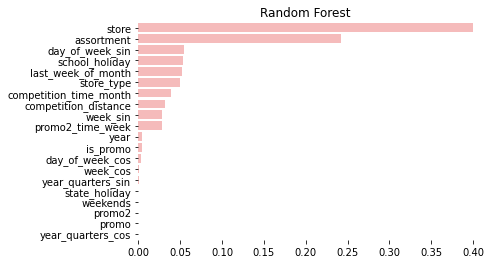

In [44]:
sns.barplot(data=importances.sort_values('rf_importances', ascending=False), x='rf_importances', y='feature', color='r', alpha=0.3)
sns.despine(left=True, bottom=True)
plt.title('Random Forest')
plt.xlim(0, 0.4)
plt.xlabel('')
plt.ylabel('');

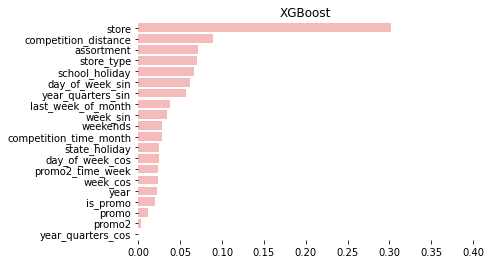

In [45]:
sns.barplot(data=importances.sort_values('xgb_importances', ascending=False), x='xgb_importances', y='feature', color='r', alpha=0.3)
sns.despine(left=True, bottom=True)
plt.title('XGBoost')
plt.xlim(0, 0.4)
plt.xlabel('')
plt.ylabel('');

In [46]:
pd.DataFrame([cols, boruta_ranking, rfe_ranking], index=['feature', 'boruta_ranking', 'rfe_ranking']).T.sort_values('rfe_ranking')

,feature,boruta_ranking,rfe_ranking
0,store,1,1
5,assortment,1,2
6,competition_distance,1,3
4,store_type,1,4
3,school_holiday,1,5
11,last_week_of_month,1,6
18,year_quarters_sin,1,7
16,week_sin,1,8
14,day_of_week_sin,1,9
15,day_of_week_cos,1,10


## 6.4 Droping Features

In [47]:
cols_feature_selection = 'is_promo state_holiday year weekends school_holiday last_week_of_month'.split()
df6.drop(cols_feature_selection, axis=1, inplace=True)
test.drop(cols_feature_selection, axis=1, inplace=True)

# 7.0 Machine Learning Modeling

In [48]:
df7 = df6.copy()

## 7.1 Splits

In [49]:
# Train and Validation
X_train = df7.loc[df7['date'] < df7['date'].max() - pd.Timedelta(6, 'w')].drop(['sales', 'date', 'store'], axis=1).values
y_train = df7.loc[df7['date'] < df7['date'].max() - pd.Timedelta(6, 'w'), 'sales'].values.ravel()

X_test = df7.loc[df7['date'] >= df7['date'].max() - pd.Timedelta(6, 'w')].drop(['sales', 'date', 'store'], axis=1).values
y_test = df7.loc[df7['date'] >= df7['date'].max() - pd.Timedelta(6, 'w'), 'sales'].values.ravel()

## 7.2 Models

### 7.2.1 Linear Regression

In [50]:
# model definition
lr_model = LinearRegression()

# fiting model
lr_fit = lr_model.fit(X_train, y_train)

# predicting
y_hat = lr_fit.predict(X_test)

# metrics
metrics(y_test, y_hat)

MAE: 1901.6835402153754
MAPE: 0.3232791462921857
RMSE: 2748.7882552688393


#### 7.2.1.1 Cross Validation

In [51]:
error = pd.DataFrame()
error, lr_cross_validation_metrics = cross_validation(df7, error, 5, 'Linear Regression', lr_model)

lr_cross_validation_metrics.T

,MAE,MAPE,RMSE
Fold: 5,1829.046897,0.294824,2571.63551
Fold: 4,1800.586109,0.296251,2539.370532
Fold: 3,2127.284598,0.285314,3091.550363
Fold: 2,2067.308393,0.28002,2987.402005
Fold: 1,1901.68354,0.290671,2748.788255
mean_and_std,1945.18 +/- 129.9,0.29 +/- 0.01,2787.75 +/- 220.03


### 7.2.2 Lasso

In [52]:
# model definition
lasso_model = Lasso()

# fiting model
lasso_fit = lasso_model.fit(X_train, y_train)

# predicting
y_hat = lasso_fit.predict(X_test)

# metrics
metrics(y_test, y_hat)

MAE: 2198.5841673367245
MAPE: 0.373751151354886
RMSE: 3110.514747133476


#### 7.2.2.1 Cross Validation

In [53]:
error, lasso_cross_validation_metrics = cross_validation(df7, error, 5, 'Lasso', lasso_model)

lasso_cross_validation_metrics.T

,MAE,MAPE,RMSE
Fold: 5,2071.962807,0.333961,2894.320362
Fold: 4,2016.375949,0.33581,2816.113093
Fold: 3,2514.35758,0.335358,3572.470979
Fold: 2,2222.852114,0.317109,3183.112874
Fold: 1,2198.584167,0.342759,3110.514747
mean_and_std,2204.83 +/- 172.82,0.33 +/- 0.01,3115.31 +/- 265.32


### 7.2.3 Random Forest

In [54]:
# model definition
rf_model = RandomForestRegressor(n_estimators=100, 
                                 min_samples_leaf=1000)

# fiting model
rf_fit = rf_model.fit(X_train, y_train)

# predicting
y_hat = rf_fit.predict(X_test)

# metrics
metrics(y_test, y_hat)

MAE: 1671.907757813132
MAPE: 0.2842181157880233
RMSE: 2436.107420402779


#### 7.2.3.1 Cross Validation

In [55]:
error, rf_cross_validation_metrics = cross_validation(df7, error, 5, 'Random Forest', rf_model)

rf_cross_validation_metrics.T

,MAE,MAPE,RMSE
Fold: 5,1684.306174,0.266908,2341.467286
Fold: 4,1600.023465,0.252428,2271.715084
Fold: 3,1957.75996,0.252423,2852.55589
Fold: 2,1792.112854,0.245669,2571.891187
Fold: 1,1670.829974,0.247253,2434.791037
mean_and_std,1741.01 +/- 124.59,0.25 +/- 0.01,2494.48 +/- 205.33


### 7.2.4 XGBoost

In [56]:
# model definition
xgb_model = XGBRegressor()

# fiting model
xgb_fit = xgb_model.fit(X_train, y_train)

# predicting
y_hat = xgb_fit.predict(X_test)

# metrics
metrics(y_test, y_hat)

MAE: 1120.2349400072007
MAPE: 0.19043578355376128
RMSE: 1689.4104498310023


#### 7.2.4.1 Cross Validation

In [57]:
error, xgb_cross_validation_metrics = cross_validation(df7, error, 5, 'XGBoost', xgb_model)

xgb_cross_validation_metrics.T

,MAE,MAPE,RMSE
Fold: 5,1083.559007,0.162836,1608.633872
Fold: 4,1007.864185,0.151561,1524.869239
Fold: 3,1397.725083,0.183112,2046.218869
Fold: 2,1195.716209,0.159659,1788.495531
Fold: 1,1120.23494,0.162057,1689.41045
mean_and_std,1161.02 +/- 132.93,0.16 +/- 0.01,1731.53 +/- 179.92


# 8.0 Model Performance

In [58]:
df8 = df7.copy()

## 8.1 Machine Learning Performance

In [59]:
error.T

,MAE,MAPE,RMSE
Linear Regression,1945.18 +/- 129.9,0.29 +/- 0.01,2787.75 +/- 220.03
Lasso,2204.83 +/- 172.82,0.33 +/- 0.01,3115.31 +/- 265.32
Random Forest,1741.01 +/- 124.59,0.25 +/- 0.01,2494.48 +/- 205.33
XGBoost,1161.02 +/- 132.93,0.16 +/- 0.01,1731.53 +/- 179.92


O modelo que seguirá para a produção será o XGBoost Regressor

## 8.2 Business Performance

# 9.0 Exportings

In [60]:
# constant_competition_distance
pickle.dump(constant_competition_distance, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\src\\features\\constant_competition_distance.pkl', 'wb'))

# month_map
pickle.dump(month_map, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\src\\features\\month_map.pkl', 'wb'))

# cols_filtering
pickle.dump(cols_filtering, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\src\\features\\cols_filtering.pkl', 'wb'))

# rs_competition_distance
pickle.dump(rs_competition_distance, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\src\\features\\rs_competition_distance.pkl', 'wb'))

# rs_competition_time_month
pickle.dump(rs_competition_time_month, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\src\\features\\rs_competition_time_month.pkl', 'wb'))

# mm_promo2_time_week
pickle.dump(mm_promo2_time_week, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\src\\features\\mm_promo2_time_week.pkl', 'wb'))

# map_state_holiday
pickle.dump(map_state_holiday, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\src\\features\\map_state_holiday.pkl', 'wb'))

# map_store_type
pickle.dump(map_store_type, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\src\\features\\map_store_type.pkl', 'wb'))

# map_assortment
pickle.dump(map_assortment, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\src\\features\\map_assortment.pkl', 'wb'))

# map_year
pickle.dump(map_year, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\src\\features\\map_year.pkl', 'wb'))

# day_of_week_cicle
pickle.dump(day_of_week_cicle, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\src\\features\\day_of_week_cicle.pkl', 'wb'))

# week_cicle
pickle.dump(week_cicle, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\src\\features\\week_cicle.pkl', 'wb'))

# year_quarters_cicle
pickle.dump(year_quarters_cicle, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\src\\features\\year_quarters_cicle.pkl', 'wb'))

# boruta_fit
pickle.dump(boruta_fit, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\data\\interim\\boruta_fit.pkl', 'wb'))

# rfe_fit
pickle.dump(rfe_fit, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\data\\interim\\rfe_fit.pkl', 'wb'))

# cols_feature_selection
pickle.dump(cols_feature_selection, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\src\\features\\cols_feature_selection.pkl', 'wb'))

# xgb_fit
pickle.dump(xgb_fit, open('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\src\\models\\xgb_fit.pkl', 'wb'))

# 10.0 API Deployed at Heroku

## 10.1 Rossmann Class

In [61]:
# import pickle
# import pandas as pd
# import inflection
# import numpy as np
# import datetime

# # path_repo = r'D:\My Drive\Pessoal\Projetos\rossmann_sales_predict\src'
# path_repo = ''

# class Rossmann(object):
#     def __init__(self):
#         # constant_competition_distance
#         self.constant_competition_distance = pickle.load(open(path_repo + r'features/constant_competition_distance.pkl', 'rb'))

#         # month_map
#         self.month_map = pickle.load(open(path_repo + r'features/month_map.pkl', 'rb'))

#         # cols_filtering
#         self.cols_filtering = pickle.load(open(path_repo + r'features/cols_filtering.pkl', 'rb'))

#         # rs_competition_distance
#         self.rs_competition_distance = pickle.load(open(path_repo + r'features/rs_competition_distance.pkl', 'rb'))

#         # rs_competition_time_month
#         self.rs_competition_time_month = pickle.load(open(path_repo + r'features/rs_competition_time_month.pkl', 'rb'))

#         # mm_promo2_time_week
#         self.mm_promo2_time_week = pickle.load(open(path_repo + r'features/mm_promo2_time_week.pkl', 'rb'))

#         # map_state_holiday
#         self.map_state_holiday = pickle.load(open(path_repo + r'features/map_state_holiday.pkl', 'rb'))

#         # map_store_type
#         self.map_store_type = pickle.load(open(path_repo + r'features/map_store_type.pkl', 'rb'))

#         # map_assortment
#         self.map_assortment = pickle.load(open(path_repo + r'features/map_assortment.pkl', 'rb'))

#         # map_year
#         self.map_year = pickle.load(open(path_repo + r'features/map_year.pkl', 'rb'))

#         # day_of_week_cicle
#         self.day_of_week_cicle = pickle.load(open(path_repo + r'features/day_of_week_cicle.pkl', 'rb'))

#         # week_cicle
#         self.week_cicle = pickle.load(open(path_repo + r'features/week_cicle.pkl', 'rb'))

#         # year_quarters_cicle
#         self.year_quarters_cicle = pickle.load(open(path_repo + r'features/year_quarters_cicle.pkl', 'rb'))

#         # cols_feature_selection
#         self.cols_feature_selection = pickle.load(open(path_repo + r'features/cols_feature_selection.pkl', 'rb'))

#         # xgb_fit
#         self.model = pickle.load(open(path_repo + r'models/xgb_fit.pkl', 'rb'))


#     def data_cleaning(self, df_raw):
#         df1 = df_raw.copy()
#         snake_case = lambda x: inflection.underscore(x)

#         cols_old = df1.columns.to_list()
#         cols_new = list(map(snake_case, cols_old))

#         # rename
#         df1.columns = cols_new

#         # changing date datatype
#         df1['date'] = pd.to_datetime(df1['date'])

#         # competition_distance
#         df1.loc[df1['competition_distance'].isna(), 'competition_distance'] = self.constant_competition_distance

#         # competition_open_since_month
#         df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if np.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

#         # competition_open_since_year
#         df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#         # promo2_since_week
#         df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if np.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#         # promo2_since_year
#         df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#         # promo_interval
#         df1['promo_interval'].fillna(0, inplace=True)
#         df1['month_map'] = df1['date'].dt.month.map(self.month_map)
#         df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
#         df1.drop(['promo_interval', 'month_map'], axis=1, inplace=True)

#         # change datatypes
#         df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int')
#         df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int')

#         df1['promo2_since_week'] = df1['promo2_since_week'].astype('int')
#         df1['promo2_since_year'] = df1['promo2_since_year'].astype('int')

#         # return df
#         return df1
    

#     def feature_engineering(self, df2):
#         # week
#         df2['week'] = df2['date'].dt.isocalendar().week

#         # year
#         df2['year'] = df2['date'].dt.year

#         # quarters
#         df2['year_quarters'] = df2['date'].dt.month.apply(lambda x: 1 if x <= 3 else (2 if x <= 6 else (3 if x <= 9 else 4)))

#         # weekends
#         df2['weekends'] = df2['date'].dt.day_name().apply(lambda x: 0 if x not in ['Friday', 'Saturday'] else 1)

#         # last_week_of_month
#         df2['last_week_of_month'] = df2['date'].dt.day.apply(lambda x: 0 if x <= 23 else 1)

#         # competition_since
#         df2['competition_since'] = df2.apply(lambda x: datetime.datetime(day=1, month=x['competition_open_since_month'], year=x['competition_open_since_year']), axis=1)
#         df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int')
#         df2.drop(['competition_since', 'competition_open_since_month', 'competition_open_since_year'], axis=1, inplace=True)

#         # promo_since
#         df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
#         df2['promo2_since'] = df2['promo2_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
#         df2['promo2_time_week'] = ((df2['date'] - df2['promo2_since']) / 7).apply(lambda x: x.days).astype(int)
#         df2.drop(['promo2_since', 'promo2_since_year', 'promo2_since_week'], axis=1, inplace=True)

#         # assortment
#         df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#         # state_holiday
#         df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

#         # day_of_week
#         df2['day_of_week'] = df2['date'].dt.day_name()

#         # return df
#         return df2


#     def data_filtering(self, df4):
#         # columns filtering
#         try:
#             cols_filtering = ['open', 'customers']
#             df4 = df4.drop(cols_filtering, axis=1)
#         except:
#             cols_filtering = ['open', 'id']
#             df4 = df4.drop(cols_filtering, axis=1)

#         # return df
#         return df4


#     def data_preparation(self, df5):
#         # 'competition_distance'
#         df5['competition_distance'] = self.rs_competition_distance.transform(df5[['competition_distance']].values)

#         # 'competition_time_month'
#         df5['competition_time_month'] = self.rs_competition_distance.transform(df5[['competition_time_month']].values)

#         # 'promo2_time_week'
#         df5['promo2_time_week'] = self.mm_promo2_time_week.transform(df5[['promo2_time_week']].values)

#         # 'state_holiday'
#         df5['state_holiday'] = df5['state_holiday'].map(self.map_state_holiday)

#         # 'store_type'
#         df5['store_type'] = df5['store_type'].map(self.map_store_type)

#         # 'assortment'
#         df5['assortment'] = df5['assortment'].map(self.map_assortment)

#         # 'year'
#         df5['year'] = df5['year'].map(self.map_year)

#         # 'day_of_week'
#         df5['day_of_week'] = df5['date'].dt.dayofweek
#         df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/self.day_of_week_cicle)))
#         df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/self.day_of_week_cicle)))
#         df5.drop('day_of_week', axis=1, inplace=True)

#         # 'week'
#         df5['week_sin'] = df5['week'].apply(lambda x: np.sin(x*(2*np.pi/self.week_cicle)))
#         df5['week_cos'] = df5['week'].apply(lambda x: np.cos(x*(2*np.pi/self.week_cicle)))
#         df5.drop('week', axis=1, inplace=True)

#         # 'year_quarters'
#         df5['year_quarters_sin'] = df5['year_quarters'].apply(lambda x: np.sin(x*(2*np.pi/self.year_quarters_cicle)))
#         df5['year_quarters_cos'] = df5['year_quarters'].apply(lambda x: np.cos(x*(2*np.pi/self.year_quarters_cicle)))
#         df5.drop('year_quarters', axis=1, inplace=True)

#         # feature selection
#         df5.drop(self.cols_feature_selection, axis=1, inplace=True)

#         # return df
#         return df5

#     def get_predictions(self, df7, df_raw):
#         # removing especific features
#         X = df7.drop(['date', 'store'], axis=1).values

#         # predicting
#         y_hat = self.model.predict(X)

#         # dataframe
#         df = df_raw.copy()
#         df['predictions'] = np.expm1(y_hat)
        
#         # return df
#         return df
        

## 10.2 Handler API

In [62]:
# import pandas as pd
# from rossmann import Rossmann
# from flask import Flask, request, Response
# import os

# # initialize API
# app = Flask(__name__)

# # create endpoint
# @app.route('/predict', methods=['POST'])

# def rossmann_predict():
#     df_raw_json = request.get_json()

#     if df_raw_json:
#         if isinstance(df_raw_json, dict):
#             df_raw = pd.DataFrame(df_raw_json, index=[0])

#         else:
#             df_raw = pd.DataFrame(df_raw_json, columns=df_raw_json[0].keys())

#         # instantiate rossmann class
#         papeline = Rossmann()

#         # data cleaning
#         df = papeline.data_cleaning(df_raw)

#         # feature engineering
#         df = papeline.feature_engineering(df)

#         # data filtering
#         df = papeline.data_filtering(df)

#         # data preparation
#         df = papeline.data_preparation(df)

#         # predicting
#         df = papeline.get_predictions(df, df_raw)

#         # return df
#         df_json = df.to_json(orient='records')
#         return df_json

#     else:
#         return Response('{}', status=200, mimetype='application/json')


# if __name__ == "__main__":
#     # starting flask
#     port = os.environ.get('PORT', 5000) # Heroku port
#     # port = 5000 # local port
#     app.run(host='0.0.0.0', port=port)


## 10.3 API Tester

In [63]:
test_raw_json = test_raw.to_json(orient='records')

# url = 'http://192.168.15.8:5000/predict'
url = 'https://api-rossmann-predict.herokuapp.com/predict'
headers = {'Content-type':'application/json'}
data = test_raw_json

df10_json = requests.post(url=url, headers=headers, data=data)

print(f'Status request code: {df10_json.status_code}')

df = pd.DataFrame(df10_json.json(), columns=df10_json.json()[0].keys())
df.head()

Status request code: 200


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,predictions
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,None,5657.671875
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",8410.045898
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,None,9338.551758
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,None,6054.614746
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,None,7727.139160


# Time

In [64]:
print(f'O tempo de processamento do projeto foi de: {int(round(time.time()-time_agora, 2)/60)} minutos')

O tempo de processamento do projeto foi de: 42 minutos
